<a href="https://colab.research.google.com/github/amamimaha/Content-based-recommender-system/blob/master/Copie_de_2_Exercises_with_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In Machine Learning models, we can know how they make predictions by visualizing features' weight. However, it is difficult to understand them when we apply them on text questions. In addition, when people try to use Neural Network (Deep Learning) models, predictions are mysterious. Feature weights are in the black box. 

In this notebook, I will apply LIME (Local Interpretable Model-agnostic Explanations), which was introduced in 2016 in a paper called ["Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938), on a simple Logistic mode and a simple NN model. The purpose of LIME is to explain a model prediction for a specific sample in a human-interpretable way.

The dataset of the Quora Insincere Questions Classification task could be downloaded from this link https://www.kaggle.com/c/quora-insincere-questions-classification/data

In [0]:
import numpy as np, pandas as pd, random as rn, time, gc, string, warnings

seed = 32
np.random.seed(seed)
rn.seed(seed)


import matplotlib.pyplot as plt
import seaborn as sns

!pip install lime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report


from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from lime import submodular_pick
from collections import OrderedDict

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

warnings.filterwarnings("ignore")
%matplotlib inline


# Exercice 1 : Predicting Sincere Questions in Quora

read train and test file

In [0]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

selecting sincere questions and insincere question

In [0]:
sincere = train[train["target"] == 0]
insincere = train[train["target"] == 1]

Building the training set as 0.9 of the data and the remaining is the validation set 

In [0]:
train = pd.concat([sincere[:int(len(sincere)*0.9)], insincere[:int(len(insincere)*0.9)]])
val = pd.concat([sincere[int(len(sincere)*0.9):], insincere[int(len(insincere)*0.9):]])

In [0]:
Transforming data to tf-idf vectors

In [0]:
tfidf_vc = TfidfVectorizer(min_df = 10,
                          max_features = 100000,
                          analyzer = "word",
                          ngram_range = (1, 2),
                          stop_words = "english",
                          lowercase = True)

train_vc = tfidf_vc.fit_transform(train["question_text"])
val_vc = tfidf_vc.transform(val["question_text"])

# Build the black box model: Logistic Regression

In [0]:
model = LogisticRegression(C = 0.5, solver = "sag")
model = model.fit(train_vc, train.target)
val_pred = model.predict(val_vc)

In [0]:
from sklearn.metrics import f1_score

val_cv = f1_score(val.target, val_pred, average = "binary")
print(val_cv)

0.0


In [0]:
idx = val.index[32]
c = make_pipeline(tfidf_vc, model)
class_names = ["sincere", "insincere"]
explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(val["question_text"][idx], c.predict_proba, num_features = 50)

print("Question: \n", val["question_text"][idx])
print("Probability (Insincere) =", c.predict_proba([val["question_text"][idx]])[0, 1])
print("True Class is:", class_names[val["target"][idx]])

Question: 
 What is the experience of an Indian-American going to India for medical school?
Probability (Insincere) = 0.060612694720345694
True Class is: sincere


In [0]:
exp.show_in_notebook()

In [0]:
exp.as_list()

[('India', 0.014413498999847547),
 ('is', 2.3761380357239815e-06),
 ('What', 2.2656237264708235e-06),
 ('medical', 2.025019622644319e-06),
 ('to', 1.8659564221417521e-06),
 ('American', 1.741347477705073e-06),
 ('going', 1.6542455156081402e-06),
 ('the', 1.5952415186706009e-06),
 ('an', 1.4811185932957266e-06),
 ('of', 1.4200098528098725e-06),
 ('Indian', 1.360149342483102e-06),
 ('for', 1.105164365449935e-06),
 ('experience', 1.0709563037658724e-06),
 ('school', 3.5909986217927633e-07)]

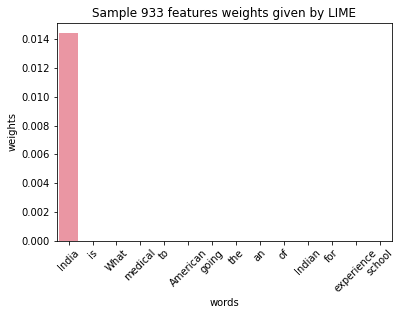

In [0]:
weights = OrderedDict(exp.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), 
                             "weights": list(weights.values())})

sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 45)
plt.title("Sample {} features weights given by LIME".format(idx))
plt.show()

As we see from above, our model consider "engineering" and "software" are negative features.

In [0]:
sp_obj = submodular_pick.SubmodularPick(explainer, val["question_text"].values, 
                                        c.predict_proba, sample_size = 10, 
                                        num_features = 50, num_exps_desired = 6,
                                        top_labels = 3)

[<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>]

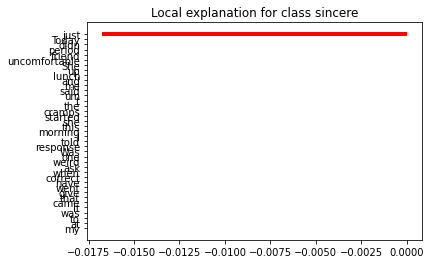

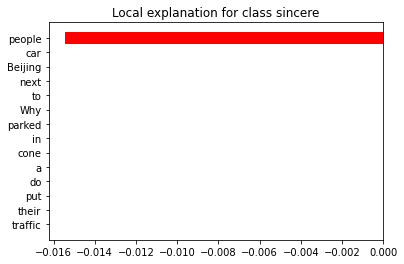

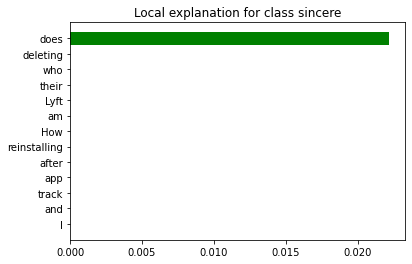

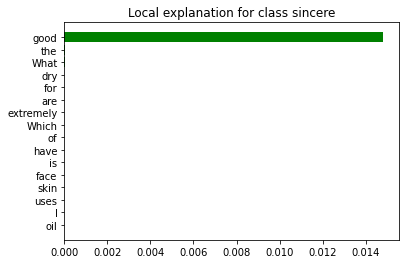

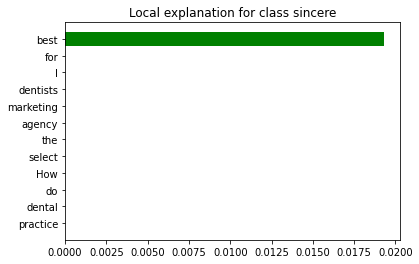

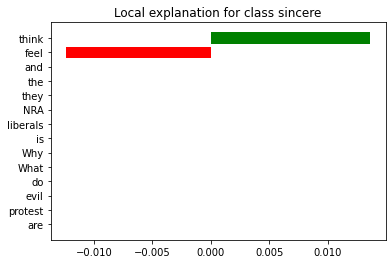

In [0]:
[exp.as_pyplot_figure(label = 0) for exp in sp_obj.sp_explanations]

# Interpreting image classifiers

The code is derived from the lime notebook examples
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [0]:
import os

import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.2.5


# Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [0]:
inet_model = inc_net.InceptionV3()

In [0]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

('n01843383', 'toucan', 0.9510553)
('n04146614', 'school_bus', 0.0015745832)
('n02058221', 'albatross', 0.0007971567)
('n01829413', 'hornbill', 0.00067058986)
('n02607072', 'anemone_fish', 0.00028791284)


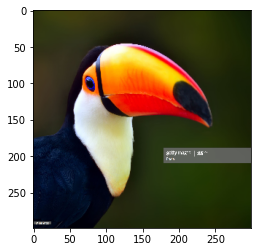

In [0]:
images = transform_img_fn([os.path.join('data','toucan.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

## Explanation
Now let's get an explanation

In [0]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [0]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

CPU times: user 10min 3s, sys: 5 s, total: 10min 8s
Wall time: 5min 12s


Image classifiers are a bit slow. Notice that an explanation on my Surface Book dGPU took 1min 29s

### Now let's see the explanation for the top class

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [0]:
from skimage.segmentation import mark_boundaries

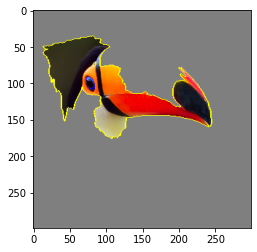

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

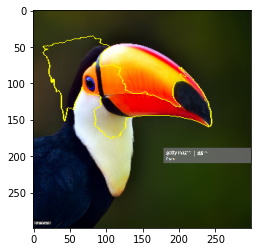

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

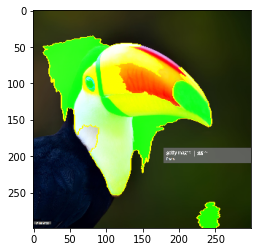

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

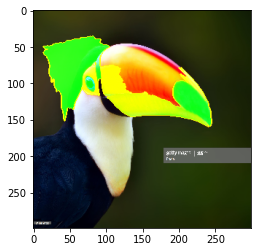

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))